In [1]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


plt.rc('font', family='Malgun Gothic')  # 폰트 지정
plt.rc('axes', unicode_minus=False)  # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'  # 그래프 글씨 뚜렷


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(42)

df_train = pd.read_csv("../data/preprocessed/df_train001.csv")

---

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [3]:
data = df_train['평균기온'].values.reshape(-1,1)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# 시계열 데이터를 RNN 입력 형식으로 변환
X, y = [], []
time_steps = 360  # 시계열 데이터의 타임 스텝 수

for i in range(len(data) - time_steps):
    X.append(data[i:i+time_steps, 0])
    y.append(data[i+time_steps, 0])

X, y = np.array(X), np.array(y)

In [6]:
# RNN 모델 생성
model = Sequential()
model.add(SimpleRNN(units=50, activation='tanh', input_shape=(time_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='huber')

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [9]:
# 모델 학습
history = model.fit(
    X.reshape(-1, time_steps, 1), y,
    epochs=100, batch_size=32,
    validation_split=0.2,  # 검증 세트 설정
    callbacks=[early_stopping]
)

Epoch 1/100

567/567 [==============================] - 16s 26ms/step - loss: 4.3900 - val_loss: 1.7107
Epoch 2/100
567/567 [==============================] - 15s 27ms/step - loss: 1.3320 - val_loss: 1.3916
Epoch 3/100
567/567 [==============================] - 15s 26ms/step - loss: 1.2725 - val_loss: 1.2825
Epoch 4/100
567/567 [==============================] - 15s 27ms/step - loss: 1.2290 - val_loss: 1.2676
Epoch 5/100
567/567 [==============================] - 15s 27ms/step - loss: 1.2251 - val_loss: 1.3142
Epoch 6/100
567/567 [==============================] - 15s 27ms/step - loss: 1.2187 - val_loss: 1.3015


---

In [10]:
sub_file = pd.read_csv("../data/original/sample_submission.csv")

In [11]:
len(sub_file)

358

In [12]:
# 여기서는 예측을 위해 앞선 time_steps일의 데이터를 사용
last_data = data[-time_steps:]

In [13]:
# 새로운 데이터를 예측
new_data = []
for i in range(358):
    prediction = model.predict(last_data.reshape(1, time_steps, 1))
    new_data.append(prediction[0, 0])
    last_data = np.roll(last_data, -1)
    last_data[-1] = prediction[0, 0]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


<AxesSubplot:>

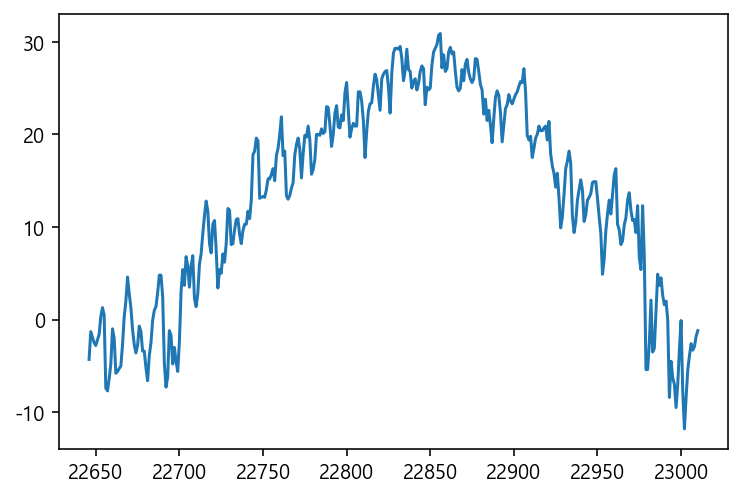

In [15]:
df_train[-365:]['평균기온'].plot()

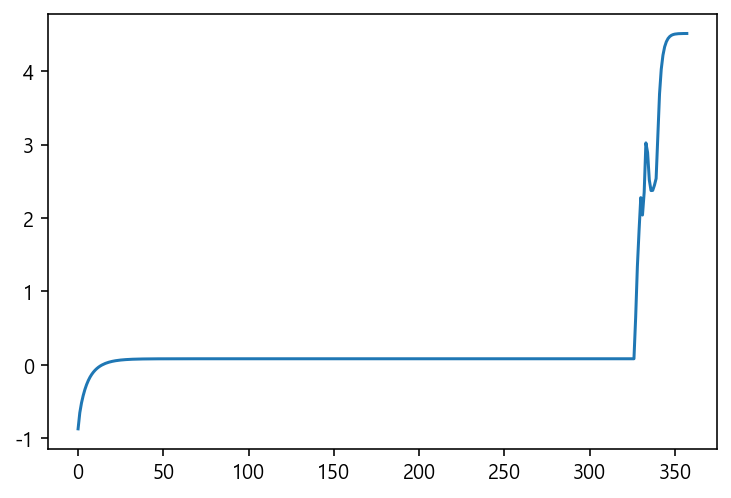

In [16]:
plt.plot(new_data)

In [17]:
sub_file['평균기온'] = new_data

In [18]:
sub_file.to_csv("../data/sub/014_RNN_002.csv",
                index=False, encoding='utf-8')

---

In [19]:
import joblib

In [20]:
joblib.dump(model, '../model/RNN_002.pkl')

['../model/RNN_002.pkl']

In [21]:
loaded_model = joblib.load('../model/RNN_002.pkl')